In [1]:
user = "admin"
passw = "AsH3saUzNX"
uri = "wheeliegood.cpd1upycyviv.us-east-1.rds.amazonaws.com"
# APIKEY = "faa0b3cb4ae90aba340567484b057e59c72b1a37"
APIKEY = "937848f62521aa822495dbe1716d5ca9ecf84fba"
NAME = "Dublin"
STATIONS = "https://api.jcdecaux.com/vls/v1/stations"
WEATHER_INFO = "https://api.openweathermap.org/data/2.5/weather"
FORECAST_INFO = "https://api.openweathermap.org/data/2.5/onecall"
FORECAST_API = "5cf5e19adac515b3f8510d2692fddc43"
WAPIKEY = "4f52f429445505a8554ffaf9b514990d"
WNAME = "2964574"
#https://api.openweathermap.org/data/2.5/onecall?lat=53.33306&lon=-6.24889&appid=5cf5e19adac515b3f8510d2692fddc43

In [272]:
from sqlalchemy import create_engine
from pandas import pandas as pd
from functools import lru_cache
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import requests
import json
import numpy as np
import datetime

In [169]:
def static_bikes():
    # Request Data from API
    engine = create_engine(f"mysql+mysqlconnector://{user}:{passw}@{uri}:3306/wheelieGood",
                           echo=True)
    # Using static bike table
    bike_data = pd.read_sql("SELECT * FROM wheelieGood.static_bikes;", engine)
    return bike_data

def dynamic_bikes():
    # Request Data from API
    engine = create_engine(f"mysql+mysqlconnector://{user}:{passw}@{uri}:3306/wheelieGood",
                           echo=True)
    # Using static bike table
    bike_data = pd.read_sql("SELECT * FROM wheelieGood.dynamic_bikes;", engine)
    return bike_data

def dynamic_weather():
    # Request Data from API
    engine = create_engine(f"mysql+mysqlconnector://{user}:{passw}@{uri}:3306/wheelieGood",
                           echo=True)
    # Using static bike table
    weather_data = pd.read_sql("SELECT * from weather", engine)
    return weather_data

In [170]:
weather = dynamic_weather()
bikes = dynamic_bikes()
static = static_bikes()
#bikes.head(2)

2021-04-05 17:26:31,548 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-05 17:26:31,549 INFO sqlalchemy.engine.base.Engine {}
2021-04-05 17:26:31,880 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-05 17:26:31,881 INFO sqlalchemy.engine.base.Engine {}
2021-04-05 17:26:32,545 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-05 17:26:32,546 INFO sqlalchemy.engine.base.Engine {}
2021-04-05 17:26:33,202 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-05 17:26:33,202 INFO sqlalchemy.engine.base.Engine {}
2021-04-05 17:26:33,531 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-05 17:26:33,532 INFO sqlalchemy.engine.base.Engine {}
2021-04-05 17:26:33,972 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT * from weather`
2021-04-05 17:26:33,973 INFO sqlalchemy.engine.base.Engine {}
2021-04-05 17:26:34,084 INFO sqla

In [7]:
weather.dtypes

coord_lon                     float64
coord_lat                     float64
weather_main                   object
weather_description            object
weather_icon                   object
main_temp                     float64
main_pressure                   int64
main_humidity                   int64
main_temp_min                 float64
main_temp_max                 float64
visibility                      int64
wind_speed                    float64
wind_deg                        int64
clouds_all                      int64
dt                     datetime64[ns]
sys_type                        int64
sys_id                          int64
sys_country                    object
sys_sunrise            datetime64[ns]
sys_sunset             datetime64[ns]
city_id                         int64
city_name                      object
cod                             int64
Current Time           datetime64[ns]
dtype: object

In [ ]:
total_stands = []
for column in bikes:
    print(column)

In [55]:
# Select columns containing categorical data
weather_categorical_columns = weather[['weather_description', 'weather_icon', 'sys_country']].columns

# Convert data type to category for these columns
for column in weather_categorical_columns:
    weather[column] = weather[column].astype('category')

In [56]:
weather_datetime_columns = weather[['Current Time', 'dt', 'sys_sunset', 'sys_sunrise']].columns

# Convert data type to datetime for these columns
for column in weather_datetime_columns:
    weather[column] = weather[column].astype('datetime64[ns]')

In [57]:
bikes.sort_values('last_update', inplace=True)
weather.sort_values('dt', inplace=True)

In [58]:
weatherTrim = weather[["weather_main", "wind_speed", "main_temp", "main_humidity", "dt"]]

adding weather types to weather table

In [59]:
weatherConditions = ["Clouds", "Clear", "Snow", "Rain", "Drizzle", "Thunderstorm"]


weatherTrim = weatherTrim.reindex(weatherTrim.columns.tolist() + weatherConditions, axis=1)
for col in weatherConditions:
    weatherTrim[col] = weatherTrim[col].replace(np.nan).fillna(0)
    
weatherTrim.loc[(weatherTrim['weather_main'] == 'Clouds'), 'Clouds'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Clear'), 'Clear'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Snow'), 'Snow'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Rain'), 'Rain'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Drizzle'), 'Drizzle'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Thunderstorm'), 'Thunderstorm'] = 1
weatherTrim.head(2)

,weather_main,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,Clouds,4.63,283.48,62,2021-03-08 13:37:42,1.0,0.0,0.0,0.0,0.0,0.0
1,Clouds,4.63,283.48,62,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0


In [84]:
weatherTrim = weatherTrim.drop(columns="weather_main")

In [85]:
bikes.dtypes

number                            int64
available_bike_stands             int64
available_bikes                   int64
last_update              datetime64[ns]
dtype: object

In [86]:
weatherTrim.dtypes

wind_speed              float64
main_temp               float64
main_humidity             int64
dt               datetime64[ns]
Clouds                  float64
Clear                   float64
Snow                    float64
Rain                    float64
Drizzle                 float64
Thunderstorm            float64
dtype: object

In [87]:
merged_data = pd.merge_asof(bikes, weatherTrim, left_on="last_update", right_on="dt")

In [88]:
# for inspection
#merged_data.to_csv("test.csv")

In [89]:
bikes.shape

(878813, 4)

In [90]:
merged_data.shape

(878813, 14)

In [91]:
data = merged_data.loc[20:684575]
data.head(2)

,number,available_bike_stands,available_bikes,last_update,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
20,5,20,20,2021-03-08 13:40:07,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0
21,89,26,14,2021-03-08 13:42:06,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0


In [92]:
# Create new column weekday
data['weekday'] = data['last_update'].dt.dayofweek
# Create new column hour
data['hour'] = data['last_update'].dt.hour
data.nunique()

<ipython-input-92-ea40cb292515>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = data['last_update'].dt.dayofweek
<ipython-input-92-ea40cb292515>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hour'] = data['last_update'].dt.hour


number                      110
available_bike_stands        41
available_bikes              41
last_update              281954
wind_speed                   27
main_temp                  1001
main_humidity                24
dt                         4609
Clouds                        2
Clear                         2
Snow                          1
Rain                          2
Drizzle                       2
Thunderstorm                  1
weekday                       7
hour                         24
dtype: int64

In [93]:
data.head(2)

,number,available_bike_stands,available_bikes,last_update,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm,weekday,hour
20,5,20,20,2021-03-08 13:40:07,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0,0,13
21,89,26,14,2021-03-08 13:42:06,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0,0,13


In [195]:
# X for the input data to be predicted on
X = data.drop(columns = ["available_bikes", "available_bike_stands", "last_update", "dt"])
# y for the out/goal set
y = data[["available_bikes"]]

In [196]:
X.head(0)

,number,wind_speed,main_temp,main_humidity,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm,weekday,hour


### _Divide into training and testing set, and test for accuracy_

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = accuracy_score(y_test, predictions)
score

0.8519925207432512

In [243]:
predictions

array([ 0, 20, 14, ...,  7, 14,  1], dtype=int64)

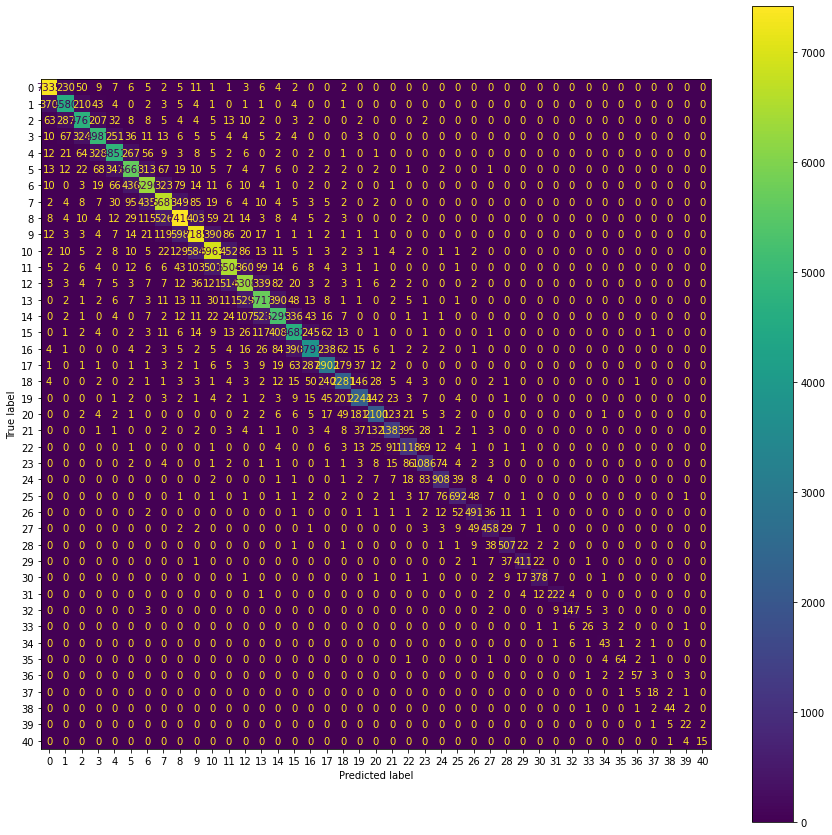

In [263]:
matrix = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(model, X_test, y_test, ax=ax)  
plt.show() 

In [273]:
#print(classification_report(X_test, y_test.values))

### _Sample Prediction_

In [242]:
# give test predictor the stand number, the wind speed, the main temp (kelvin) 
# the humidity, the weekday number, and the hour of the day
userInput = 12
prediction = model.predict([[userInput, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
prediction_values = prediction[0]
prediction_values

17

### Sample Output

test sample row

In [187]:
static[static["number"] == userInput]

,number,name,address,pos_lat,pos_lng,bike_stands
76,12,ECCLES STREET,Eccles Street,53.3592,-6.26978,20


Output

In [194]:
# apply the user's chosen station to the static table
userStation = static[static["number"] == userInput]
print(f"Predicted Bikes: {prediction_values[0]}")

# subtact predicted bikes avail from total bike stands
remaining_stands = userStation["bike_stands"].values.tolist() - prediction_values[0]
print(f"Predicted Remaining Stands: {remaining_stands[0]}")

Predicted Bikes: 17
Predicted Remaining Stands: 3


## _Random Forest_

In [236]:
randModel = RandomForestClassifier(n_estimators = 10, random_state=30)
randModel.fit(X_train, y_train.values.ravel())
forestPrediction = model.predict([[userInput, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
forestPrediction

array([17], dtype=int64)

In [237]:
predictionTest = model.predict(X_test)
forestScore = accuracy_score(y_test, predictionTest)
forestScore

0.8519925207432512

In [244]:
predictionTest

array([ 0, 20, 14, ...,  7, 14,  1], dtype=int64)

### Check feature importances

In [228]:
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_, index=feature_list)
feature_imp.sort_values(ascending=False)

main_temp        0.289069
hour             0.202397
number           0.194067
wind_speed       0.118289
weekday          0.097616
main_humidity    0.072015
Clear            0.011143
Clouds           0.008215
Rain             0.005963
Drizzle          0.001226
Snow             0.000000
Thunderstorm     0.000000
dtype: float64

## K-Nearest Neighbour

In [234]:
knn_model = KNeighborsClassifier(n_neighbors = 10)
knn_model.fit(X_train, y_train.values.ravel())
knn_prediction = model.predict([[userInput, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
knn_prediction

array([17], dtype=int64)

In [235]:
knnTest = model.predict(X_test)
knnScore = accuracy_score(y_test, knnTest)
knnScore

0.8519925207432512

In [246]:
knnTest

array([ 0, 20, 14, ...,  7, 14,  1], dtype=int64)

## Linear Regression

In [274]:
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
linear_prediction = linearModel.predict([[userInput, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
linear_prediction

array([[0.77165104]])

# 2. _Take incoming data and format to meet model requirements_

In [99]:
forecast = requests.get("https://api.openweathermap.org/data/2.5/onecall?lat=53.33306&lon=-6.24889&exclude=current,minutely&appid=5cf5e19adac515b3f8510d2692fddc43")
forecast

<Response [200]>

In [120]:
forecast_data = forecast.json()

In [122]:
# iterate over the json array to get the hourly data
hourly_data = 0
for k, v in forecast_data.items():
    if k == "hourly":
        hourly_data = v

for x in range(len(hourly_data)):
    hourly_data[x]

# convert the hourly data to a dataframe
df = pd.DataFrame.from_dict(pd.json_normalize(hourly_data), orient='columns')
df.head(2)

,dt,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather,pop,snow.1h
0,1617634800,279.18,275.09,1026,49,269.72,1.88,20,10000,6.70,356,9.58,"[{'id': 801, 'main': 'Clouds', 'description': ...",0.0,NaN
1,1617638400,278.96,274.74,1026,50,269.78,1.26,59,10000,6.91,354,9.56,"[{'id': 803, 'main': 'Clouds', 'description': ...",0.0,NaN


### Create a list of weather values that corresponds with the value in the inner array per row

In [112]:
weatherValues = []
for x in df["weather"]:
    currentRow = x[0]
    for key, value in currentRow.items():
        if key == "main":
            weatherValues.append(value)
            
print(weatherValues)

['Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Snow', 'Snow', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Snow', 'Snow', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds']


### As we did before, create rows that correspond to these values

In [125]:
df = df.reindex(df.columns.tolist() + weatherConditions, axis=1)
for col in df:
    df[col] = df[col].replace(np.nan).fillna(0)
df.head(2)

,dt,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,...,wind_gust,weather,pop,snow.1h,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,1617634800,279.18,275.09,1026,49,269.72,1.88,20,10000,6.70,...,9.58,"[{'id': 801, 'main': 'Clouds', 'description': ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1617638400,278.96,274.74,1026,50,269.78,1.26,59,10000,6.91,...,9.56,"[{'id': 803, 'main': 'Clouds', 'description': ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
for x in range(len(weatherValues)):
    for column in df.columns:
        if weatherValues[x] == column:
            df.at[x, column] = 1
df.head(2)

,dt,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,...,wind_gust,weather,pop,snow.1h,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,1617634800,279.18,275.09,1026,49,269.72,1.88,20,10000,6.70,...,9.58,"[{'id': 801, 'main': 'Clouds', 'description': ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1617638400,278.96,274.74,1026,50,269.78,1.26,59,10000,6.91,...,9.56,"[{'id': 803, 'main': 'Clouds', 'description': ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Dump un-needed columns

In [138]:
# get rid of the unneeded rows
weather_df = df[["dt", "temp", "wind_speed", "humidity", "Clouds", "Clear", "Snow", "Rain", "Drizzle", "Thunderstorm"]]
weather_df.head(2)

,dt,temp,wind_speed,humidity,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,1617634800,279.18,6.70,49,1.0,0.0,0.0,0.0,0.0,0.0
1,1617638400,278.96,6.91,50,1.0,0.0,0.0,0.0,0.0,0.0


In [139]:
df.dtypes

dt                int64
temp            float64
feels_like      float64
pressure          int64
humidity          int64
dew_point       float64
uvi             float64
clouds            int64
visibility        int64
wind_speed      float64
wind_deg          int64
wind_gust       float64
weather          object
pop             float64
snow.1h         float64
Clouds          float64
Clear           float64
Snow            float64
Rain            float64
Drizzle         float64
Thunderstorm    float64
dtype: object

In [140]:
# convert from unix epoch time to useable format...
from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time
weather_df['datetime'] = weather_df.dt.apply(lambda x: start + timedelta(seconds=x))

<ipython-input-140-4c7db20836c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['datetime'] = weather_df.dt.apply(lambda x: start + timedelta(seconds=x))


In [141]:
# dt is no longer needed
weather_df = weather_df.drop(columns= ["dt"])
weather_df.dtypes

temp                   float64
wind_speed             float64
humidity                 int64
Clouds                 float64
Clear                  float64
Snow                   float64
Rain                   float64
Drizzle                float64
Thunderstorm           float64
datetime        datetime64[ns]
dtype: object

In [142]:
# Create new column weekday
weather_df['weekday'] = weather_df['datetime'].dt.dayofweek
# Create new column hour
weather_df['hour'] = weather_df['datetime'].dt.hour

# dump now defunct datetime column
weather_df = weather_df.drop(columns= ["datetime"])

In [143]:
weather_df.head(2)

,temp,wind_speed,humidity,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm,weekday,hour
0,279.18,6.70,49,1.0,0.0,0.0,0.0,0.0,0.0,0,15
1,278.96,6.91,50,1.0,0.0,0.0,0.0,0.0,0.0,0,16


In [144]:
weather_df.nunique()

temp            45
wind_speed      46
humidity        31
Clouds           2
Clear            2
Snow             2
Rain             1
Drizzle          1
Thunderstorm     1
weekday          3
hour            24
dtype: int64

In [145]:
weather_df.shape

(48, 11)

# create a dummy weather data set and insert a dummy station number at FIRST INDEX

In [147]:
# insert station number
desired_row = weather_df.iloc[1].tolist()
desired_row.insert(0, 12)

In [148]:
# give test predictor the list of user input variables (in this case, a dummy set)
prediction = model.predict([desired_row])
prediction_values = prediction[0]

#sample output
print(f"Station number {desired_row[0]}")
print("-------------------")
print(f"Predicted available bikes at  : {prediction_values[0]} ")
print(f"Predicted available bike stands : {prediction_values[1]}")

Station number 12
-------------------
Predicted available bikes at  : 1 
Predicted available bike stands : 19
